## Imports

In [41]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from PyBNG import PyBNG
import shapely
from os import makedirs, path, listdir, remove
import matplotlib.pyplot as plt
import requests
import zipfile as zpf
from tqdm import tqdm
from PIL import Image

## netCDF files: Processing & exploration

In [42]:
folder = "/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/001/"

In [43]:
files = [path.join(folder, file) for file in listdir(folder) if path.splitext(file)[-1]==".nc"]

In [44]:
ds = xr.open_dataset(files[0])

In [45]:
ds

<xarray.Dataset>
Dimensions:                               (nPoints_XY: 7574, nPoints_XYZ: 7574, nMetLines: 7, nGroups: 1, nDatasets: 5, OutputOptionsUsed: 3, NumberOfTypesOfOutputPoint: 5)
Dimensions without coordinates: nPoints_XY, nPoints_XYZ, nMetLines, nGroups, nDatasets, OutputOptionsUsed, NumberOfTypesOfOutputPoint
Data variables: (12/23)
    PointX_XY                             (nPoints_XY) float32 ...
    PointY_XY                             (nPoints_XY) float32 ...
    PointName_XY                          (nPoints_XY) |S44 ...
    PointX_XYZ                            (nPoints_XYZ) float32 ...
    PointY_XYZ                            (nPoints_XYZ) float32 ...
    PointZ_XYZ                            (nPoints_XYZ) float32 ...
    ...                                    ...
    Dataset4                              (nMetLines, nGroups, nPoints_XYZ) float32 ...
    Dataset5                              (nMetLines, nGroups, nPoints_XYZ) float32 ...
    Output_Options_Description            (OutputOptionsUsed) |S14 ...
    Output_Options_Used                   (OutputOptionsUsed) int32 ...
    Output_Points_Type                    (NumberOfTypesOfOutputPoint) |S16 ...
    Number_Of_Output_Points_Of_Each_Type  (NumberOfTypesOfOutputPoint) int32 ...
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  Greater London
    Project_Name:               Preliminary 2019 with P-G classes
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               9/12/2021
    Time_Created:               16:6:26

There is a Dataset for each pollutant species, e.g. the NO2 data is contained in `Dataset2`.

Each pollutant dataset has 7 Pasquill-Gifford weather condition classes, represented by met lines, and a space dimension, represented by XYZ point number. Each pollutant dataset also has a Groups dimension, which indicates a subset of emission sources (here there is only one Group, for "All sources").

To identify the Pasquill-Gifford class, a separate `Met_Line` dataset is numbered from 1 to 7.

To identify the spatial coordinates (OSGB (British National Grid)), the `PointX_XYZ`, `PointY_XYZ`, and `PointZ_XYZ` datasets contain the X, Y, and Z coordinates respectively.

The DataArray can be indexed like a `numpy` array e.g. to obtain only the concentrations through time at one spatial point e.g. `NO2_da[:,0,0].values`.

The DataArray can also be averaged over a dimension like a `numpy` array e.g. spatially averaged timeseries: `NO2_da.mean(axis=2).squeeze().values`. The `.squeeze()` function squeezes out the Groups dimension, since it has size 1.

Let's extract the datetime information from the Met_Line dataset:

In [46]:
def metline_to_datetime(i):
    numbers = str(i).replace("b", "").replace("'", "")
    return np.datetime64(f"{numbers[0]}")+ np.timedelta64(int(numbers[1])-1, "D") + np.timedelta64(int(numbers[2]), "h")

def extract_dataset_time_axis(ds):
    datetime_index = []
    for i in ds.Met_Line.values:
        datetime_index.append(metline_to_datetime(i))
    return datetime_index

In [ ]:
# datetime_index = extract_dataset_time_axis(ds)

Now we can plot a spatial average timeseries for NO2:

In [47]:
def plot_timeseries(dataframe, columns, title, units, figure_size=(8,4)):
    plt.figure(figsize=figure_size, dpi=300)
    for column in columns:
        dataframe[column].plot()
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(title)
    plt.show()

Missing values are assigned as `-999` during ADMS-Urban modelling, so we replace these with NaNs.
NOTE: I think there aren't actually any -999 values in the data, just some really high concentrations.

In [ ]:
# plot_timeseries(dataframe=pd.DataFrame(ds.Dataset2.mean(axis=2).squeeze().values, index=datetime_index, columns=["spatial_mean_NO2"]).replace(-999, np.nan), 
#                 columns=["spatial_mean_NO2"], 
#                 title="Hourly ADMS-Urban predictions for London subset 00034", 
#                 units="NO$_2$ (µg m$^{-3}$)")

### Pasquill-Gifford classes

In [48]:
PG_index = ["A", "B", "C", "D", "E", "F", "G"]

### Space

The `PyBNG` library enables interconversion between the Ordnance Survey British National Grid (OS BNG) coordinates and latitude/longitude coordinates, which will be more useful for plotting and further analysis.

In [49]:
def PointXYZ_to_latlon(PointXs, PointYs):
    df = pd.DataFrame()
    for X, Y in zip(PointXs.astype(int), PointYs.astype(int)):
        latlon = PyBNG(easting=X, northing=Y).get_latlon()
        df = df.append([latlon])
    df.columns = ["latitude", "longitude"]
    df.reset_index(drop=True, inplace=True)
    return df

<AxesSubplot:>

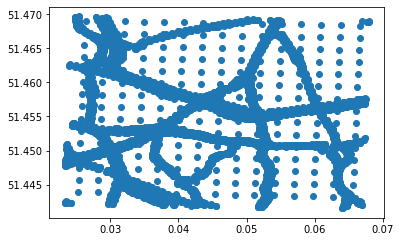

In [50]:
latlon_df = PointXYZ_to_latlon(ds.PointX_XYZ.values, 
                                  ds.PointY_XYZ.values)
gdf = gpd.GeoDataFrame(latlon_df, geometry=gpd.points_from_xy(latlon_df.longitude, latlon_df.latitude))

gdf.plot()

To plot this on a map of London, we can download the London borough GIS boundaries from the London Datastore:

In [51]:
url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"
tmp_folder = path.join(path.abspath(""), "tmp")
filename = path.basename(url)
filepath = path.join(tmp_folder, filename)

In [52]:
new_download = False

if new_download:
    file = open(filepath, 'wb')
    file.write(requests.get(url).content)
    file.close()
    zpf.ZipFile(filepath, 'r').extractall(tmp_folder)

Load the London Boroughs shapefile and convert to the latitude/longitude coordinate system by referencing the EPSG code `4326`:

In [53]:
shapefilepath = path.join(tmp_folder, "statistical-gis-boundaries-london", "ESRI",
                         "London_Borough_Excluding_MHW.shp")
london_boroughs_gdf = gpd.read_file(shapefilepath).to_crs(epsg=4326)

CRSError: Invalid projection: epsg:4326: (Internal Proj Error: proj_create: no database context specified)

In [54]:
import matplotlib.colors as colors

def plot_on_map(data_geodataframe, map_geodataframe, column=None, title="Greater London", fontsize="25", figsize=(20,10), data_color=None, data_cmap=None, colorbar=False, set_colorbar_max=False, set_colorbar_log=False, data_markersize=0.1, map_color="whitesmoke", map_edge_color="black", axis="off"):
    data_geodataframe.plot(column=column, ax=map_geodataframe.plot(figsize=figsize, color=map_color, edgecolor=map_edge_color),
                          color=data_color, cmap=data_cmap, markersize=data_markersize)
    if colorbar:
        if set_colorbar_max:
            colorbar_max = set_colorbar_max
        else:
            colorbar_max = data_geodataframe[column].max()
        if set_colorbar_log:
            norm = colors.LogNorm(data_geodataframe[column].quantile(0.01), colorbar_max)
        else:
            norm = plt.Normalize(data_geodataframe[column].min(), colorbar_max)
        plt.colorbar(plt.cm.ScalarMappable(cmap=data_cmap, 
        norm=norm)).set_label(column)
    plt.suptitle(title, fontsize=fontsize)
    plt.axis(axis)
    plt.show()

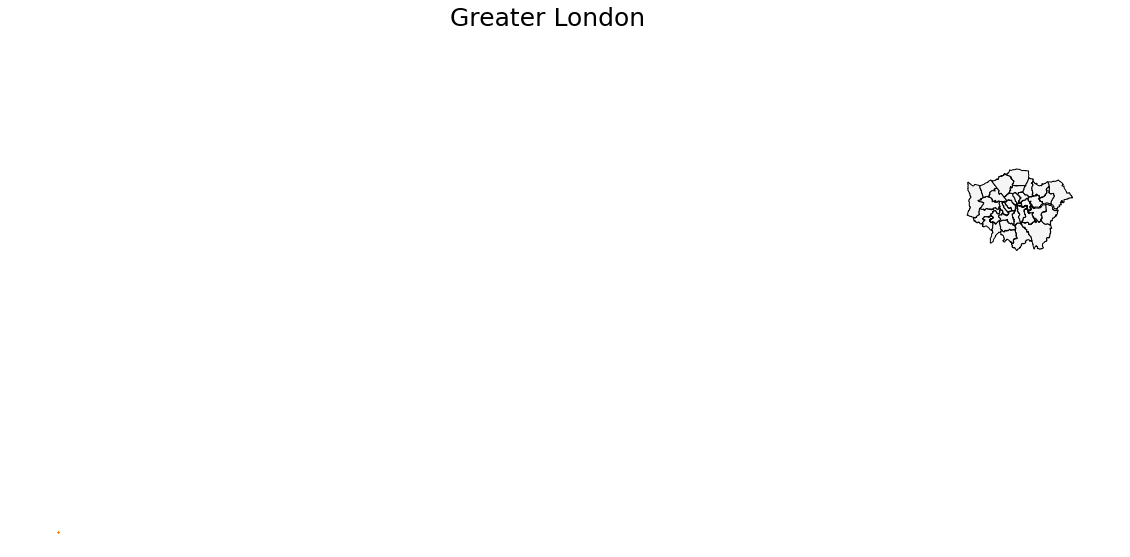

In [55]:
plot_on_map(gdf, london_boroughs_gdf, data_color="tab:orange")

Select a Pasquill-Gifford class to estimate NO2 concentration at each output point and join the GeoDataFrame with the spatial points:

In [76]:
choose_PG_class = "A"

In [57]:
space_gdf = gpd.GeoDataFrame(ds.Dataset2[PG_index.index(choose_PG_class),0,:].squeeze().values, 
                  index=gdf.index, 
                  columns=[f"Class_{choose_PG_class}_NO2"]).join(gdf)

In [82]:
def plot_in_grid_box(geodataframe, column, title, figsize=(10,5), fontsize=15, markersize=0.1, cmap="plasma_r", colorbar=True, edgecolor=None):
    geodataframe.plot(column=column, figsize=figsize, markersize=markersize, cmap=cmap, edgecolor=edgecolor)
    plt.colorbar(
        plt.cm.ScalarMappable(
            cmap=cmap, 
            norm=plt.Normalize(geodataframe[column].min(), geodataframe[column].max())))
    plt.suptitle(title, fontsize=fontsize)
    plt.show()

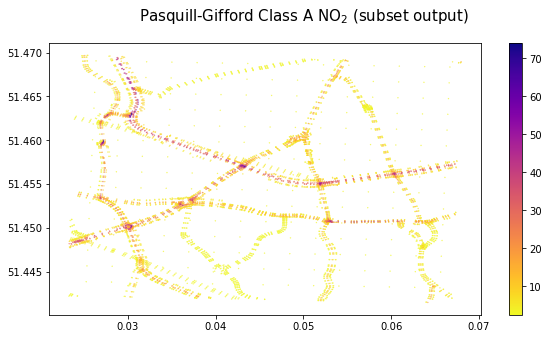

In [83]:
plot_in_grid_box(space_gdf, f"Class_{choose_PG_class}_NO2", title=f"Pasquill-Gifford Class {choose_PG_class} NO$_2$ (subset output)")

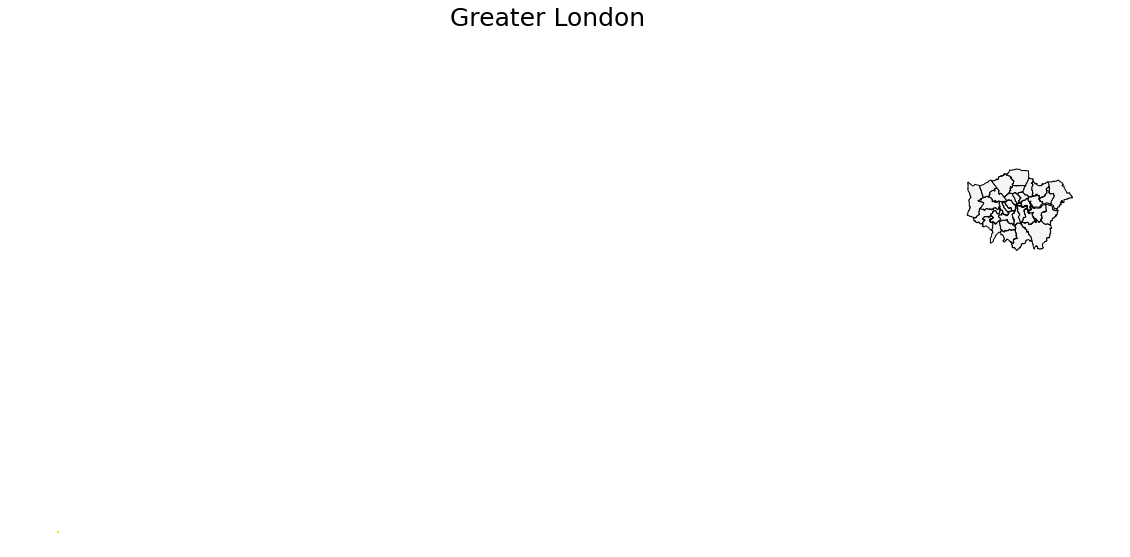

In [60]:
plot_on_map(space_gdf, london_boroughs_gdf, column=f"Class_{choose_PG_class}_NO2", data_cmap="plasma_r")

### New Dataset

We can make a new Dataset containing all of the pollutant concentrations, as well as meteorological variables:

In [61]:
def process_dataset(ds):
    data_variables = {
        ds.Dataset1.Pollutant_Name: (["PG_class", "space"], ds.Dataset1.values.squeeze(), ds.Dataset1.attrs),
        ds.Dataset2.Pollutant_Name: (["PG_class", "space"], ds.Dataset2.values.squeeze(), ds.Dataset2.attrs),
        ds.Dataset3.Pollutant_Name: (["PG_class", "space"], ds.Dataset3.values.squeeze(), ds.Dataset3.attrs),
        ds.Dataset4.Pollutant_Name: (["PG_class", "space"], ds.Dataset4.values.squeeze(), ds.Dataset4.attrs),
        ds.Dataset5.Pollutant_Name: (["PG_class", "space"], ds.Dataset5.values.squeeze(), ds.Dataset5.attrs),
        "wind_speed_at_10m": (["PG_class"], ds.Met_UAt10m.values.squeeze(), ds.Met_UAt10m.attrs),
        "wind_direction": (["PG_class"], ds.Met_PHI.values.squeeze(), ds.Met_PHI.attrs)
                     }

    coords = {"Pasquill-Gifford": (["PG_class"], np.array(PG_index)),
         "latitude": (["space"], PointXYZ_to_latlon(ds.PointX_XYZ.values, ds.PointY_XYZ.values).latitude.values),
         "longitude": (["space"], PointXYZ_to_latlon(ds.PointX_XYZ.values, ds.PointY_XYZ.values).longitude.values)}

    attrs = ds.attrs

    return xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

Let's try loading multiple netCDF files:

In [62]:
files[:5]

['/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/001/001.00015.nc',
 '/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/001/001.00155.nc',
 '/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/001/001.00044.nc',
 '/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/001/001.00295.nc',
 '/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/001/001.00104.nc']

We concatentate the xarray datasets along the `space` dimension:

In [63]:
progress_bar = tqdm(range(0, len(files)))

new_ds = xr.concat([process_dataset(xr.open_dataset(files[i])) for i in progress_bar], "space")

100%|██████████| 359/359 [43:39<00:00,  7.30s/it] 


In [64]:
new_ds

<xarray.Dataset>
Dimensions:            (PG_class: 7, space: 1344773)
Coordinates:
    Pasquill-Gifford   (PG_class) <U1 'A' 'B' 'C' 'D' 'E' 'F' 'G'
    latitude           (space) float64 51.44 51.44 51.44 ... 51.27 51.27 51.27
    longitude          (space) float64 0.02525 0.02812 ... -0.01588 -0.01575
Dimensions without coordinates: PG_class, space
Data variables:
    NOx                (PG_class, space) float32 16.43 16.31 ... 290.8 102.4
    NO2                (PG_class, space) float32 2.729 2.696 ... 72.22 25.31
    PM10               (PG_class, space) float32 1.557 1.545 ... 29.77 10.7
    PM2.5              (PG_class, space) float32 0.8628 0.8608 ... 12.89 4.776
    CO2                (PG_class, space) float32 1.007e+04 ... 5.652e+04
    wind_speed_at_10m  (space, PG_class) float32 0.9995 2.0 4.999 ... 2.0 1.0
    wind_direction     (space, PG_class) float32 270.0 270.0 ... 270.0 270.0
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  Greater London
    Project_Name:               Preliminary 2019 with P-G classes
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               9/12/2021
    Time_Created:               16:6:26

In [69]:
# Save this for reloading later
new_ds.to_netcdf(path.join(folder, "raw_processed_coordinates.nc"))

Now we can make a Geopandas Dataframe for plotting:

In [90]:
choose_PG_class = "A"
data_column = f"Class_{choose_PG_class}_NO2"

In [85]:
new_gdf = gpd.GeoDataFrame(new_ds.NO2[PG_index.index(choose_PG_class),:].values, 
                 columns=[data_column], 
                 geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))

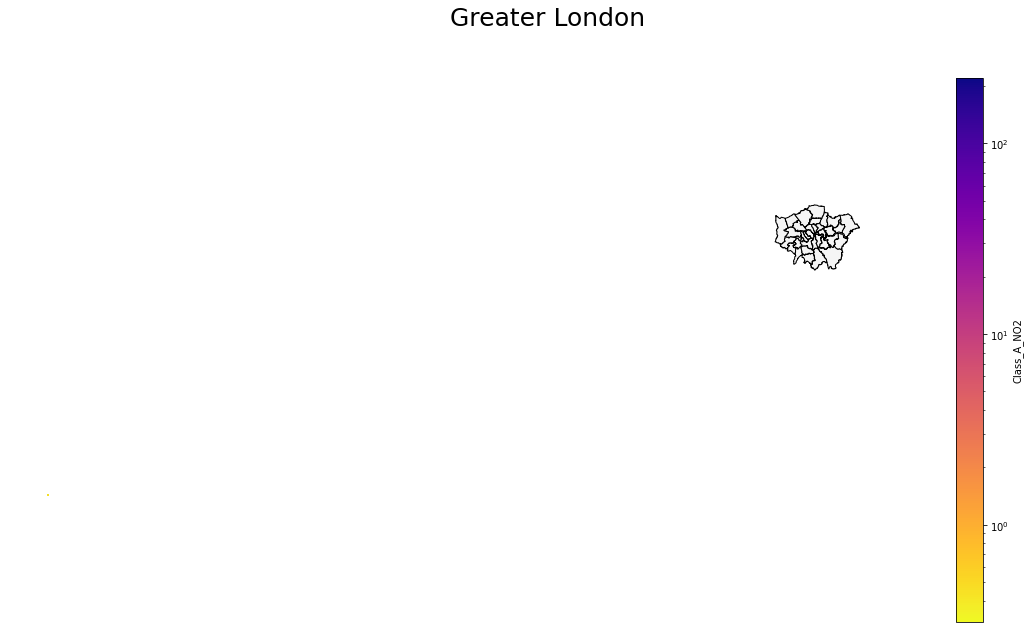

In [86]:
plot_on_map(new_gdf, london_boroughs_gdf, column=data_column, 
            data_cmap="plasma_r", colorbar=True, set_colorbar_log=True)

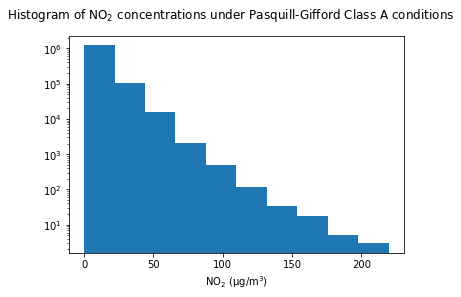

In [87]:
plt.hist(new_gdf[data_column].values)
plt.suptitle(f"Histogram of NO$_2$ concentrations under Pasquill-Gifford Class {choose_PG_class} conditions")
plt.yscale("log")
plt.xlabel("NO$_2$ (μg/m$^3$)")
plt.show()

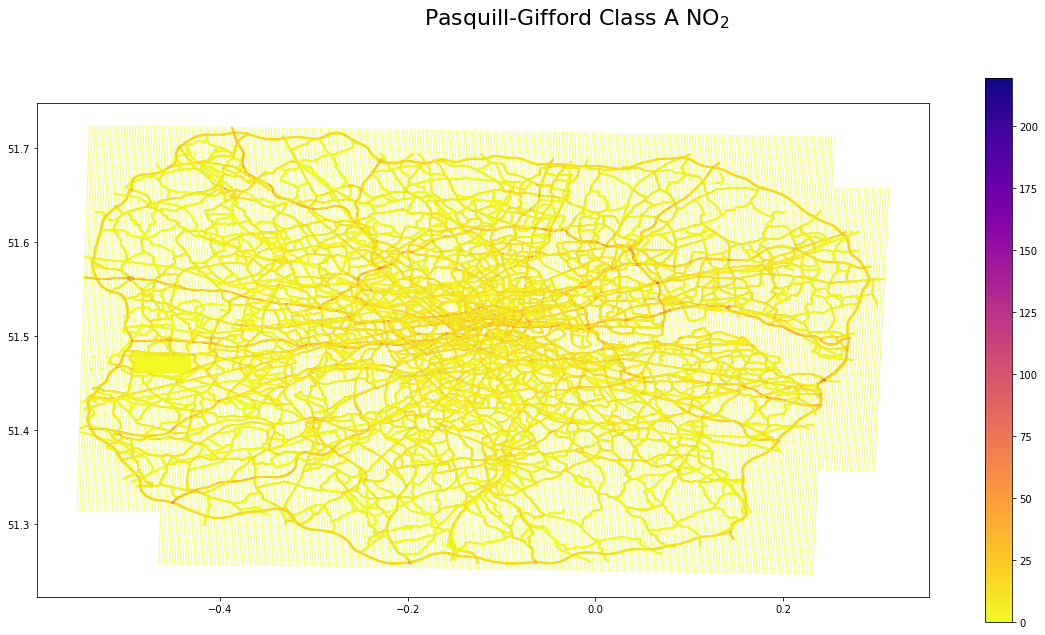

In [88]:
plot_in_grid_box(new_gdf, 
                 data_column, 
                 figsize=(20,10),
                 title=f"Pasquill-Gifford Class {choose_PG_class} NO$_2$", 
                 fontsize=22)

#### Re-gridding

So I'm currently using a dataset which is indexed by time and space i.e. my spatial dimension is a long list of coordinates indexed by longitude-latitude, rather than with longitude and latitude indexed separately so that the space is 2D.

Let's try gridding the data.

Adapted from [this tutorial](https://james-brennan.github.io/posts/fast_gridding_geopandas/).

In [140]:
xmin, ymin, xmax, ymax = new_gdf.total_bounds
n_cells = 10
cell_size = (xmax-xmin)/n_cells
grid_cells = [shapely.geometry.box(x0, y0, x0 - cell_size, y0 + cell_size) 
              for x0 in np.arange(xmin, xmax + cell_size, cell_size) 
              for y0 in np.arange(ymin, ymax + cell_size, cell_size)]

cell = gpd.GeoDataFrame(grid_cells, columns=["geometry"])

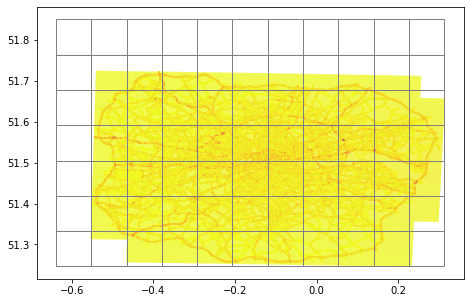

In [141]:
cell.plot(ax=new_gdf.plot(markersize=0.1, column=data_column, cmap="plasma_r", figsize=(10,5)), 
          facecolor="none", edgecolor="grey")
plt.show()

Merge the grid with the data points themselves:

In [142]:
merged_gdf = gpd.sjoin(new_gdf, cell, how="left", predicate="within")

Use the `.dissolve()` function to upsample the data to the grid:

In [143]:
dissolve = merged_gdf.dissolve(by="index_right", aggfunc="mean")
cell.loc[dissolve.index, data_column] = dissolve[data_column].values

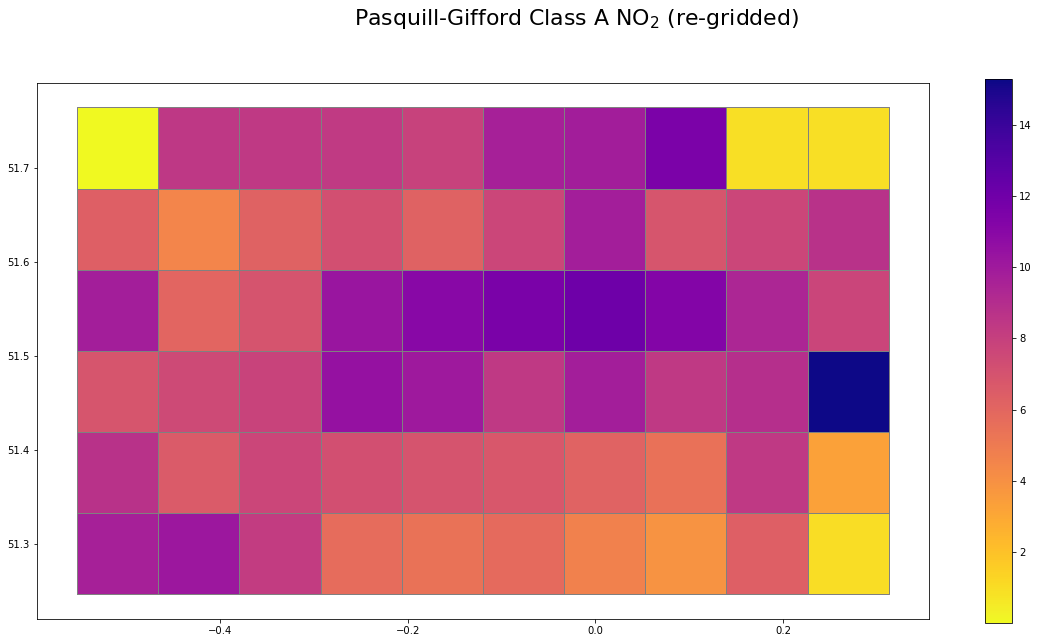

In [144]:
plot_in_grid_box(cell, 
                 data_column, 
                 figsize=(20,10), 
                 fontsize=22, 
                 title=f"Pasquill-Gifford Class {choose_PG_class} NO$_2$ (re-gridded)", 
                 edgecolor="grey")

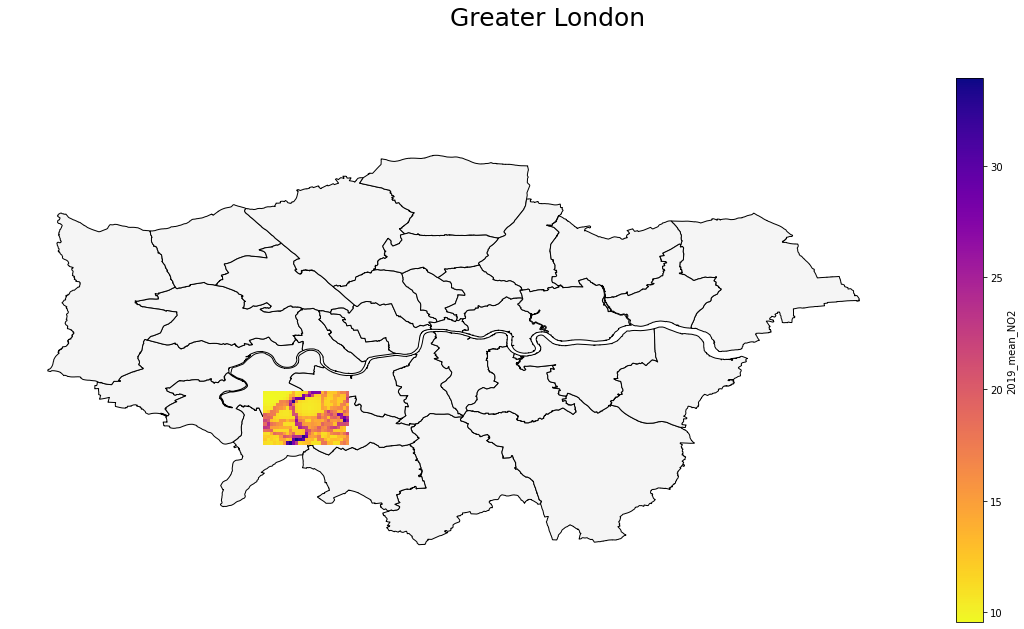

In [77]:
plot_on_map(cell, london_boroughs_gdf, column=data_column, data_cmap="plasma_r", colorbar=True)

In [145]:
# What are the reshaping dimensions?
print(len(cell.centroid.x.drop_duplicates()),
len(cell.centroid.y.drop_duplicates()))
print((len(cell.centroid.x.drop_duplicates())+1) * (len(cell.centroid.y.drop_duplicates())+1))
print(len(cell))

11 13
168
77


In [164]:
set(cell.centroid.y)

{51.28913219802308,
 51.28913219802309,
 51.375591572235244,
 51.37559157223525,
 51.46205094644743,
 51.462050946447434,
 51.548510320659595,
 51.5485103206596,
 51.63496969487177,
 51.63496969487178,
 51.721429069083946,
 51.72142906908396,
 51.807888443296136}

In [167]:
cell.centroid.y.values[0]

51.28913219802308

In [147]:
cell.centroid

0     POINT (-0.59522 51.28913)
1     POINT (-0.59522 51.37559)
2     POINT (-0.59522 51.46205)
3     POINT (-0.59522 51.54851)
4     POINT (-0.59522 51.63497)
                ...            
72     POINT (0.26938 51.46205)
73     POINT (0.26938 51.54851)
74     POINT (0.26938 51.63497)
75     POINT (0.26938 51.72143)
76     POINT (0.26938 51.80789)
Length: 77, dtype: geometry

This Pasquill-Gifford class data can be reshaped (what dimensions?) and made into an `xarray` dataset:

In [130]:
data_variables = {"NO2": (["longitude", "latitude"], cell[data_column].values.reshape(28, 18), new_ds.NO2.attrs)
                    }

coords = {"longitude": (["longitude"], cell.centroid.x.drop_duplicates()),
            "latitude": (["latitude"], cell.centroid.y.drop_duplicates())}
     
attrs = new_ds.attrs

NO2_ds = xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

ValueError: cannot reshape array of size 12684 into shape (28,18)

In [ ]:
NO2_ds

#### Timeseries re-gridding

For the processed timeseries `xarray` dataset, we need to re-grid each timestep and then reshape it...

In [26]:
new_ds.datetime

<xarray.DataArray 'datetime' (time: 8760)>
array(['2019-01-01T01:00:00.000000000', '2019-01-01T02:00:00.000000000',
       '2019-01-01T03:00:00.000000000', ...,
       '2019-12-31T22:00:00.000000000', '2019-12-31T23:00:00.000000000',
       '2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    datetime  (time) datetime64[ns] 2019-01-01T01:00:00 ... 2020-01-01
Dimensions without coordinates: time

In [27]:
new_ds.NO2.values.shape

(8760, 20025)

I could loop through each time step and use `geopandas` to convert to a lat/lon grid, then stack the timesteps into a `numpy` array to then make into an `xarray` dataset:

In [28]:
xmin, ymin, xmax, ymax = gpd.points_from_xy(new_ds.longitude.values, 
                                            new_ds.latitude.values).total_bounds
n_cells = 27
cell_size = (xmax-xmin)/n_cells
grid_cells = [shapely.geometry.box(x0, y0, x0 - cell_size, y0 + cell_size) 
              for x0 in np.arange(xmin, xmax + cell_size, cell_size) 
              for y0 in np.arange(ymin, ymax + cell_size, cell_size)]

ref_cell = gpd.GeoDataFrame(grid_cells, columns=["geometry"])

#### For NO2 only

In [156]:
cell_list = []
progress_bar = tqdm(range(0, new_ds.datetime.shape[0]))

for i in progress_bar:
    progress_bar.set_description(f"Gridding timesteps")
    cell = ref_cell.copy()
    timestep_gdf = gpd.GeoDataFrame(new_ds.NO2[i, :].values, 
                     columns=["timestep_NO2"], 
                     geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))
    merge = gpd.sjoin(timestep_gdf, ref_cell, how="left", predicate="within")
    dissolve = merge.dissolve(by="index_right", aggfunc="mean")
    cell.loc[dissolve.index, "timestep_NO2"] = dissolve["timestep_NO2"].values
    cell_list.append(cell["timestep_NO2"].values.reshape(28,18))

Gridding timestep 8759 of 8760.: 100%|██████████| 8760/8760 [4:10:09<00:00,  1.71s/it]  


In [157]:
timeseries_gridded = np.stack(cell_list, axis=-1)

timeseries_gridded.shape

(28, 18, 8760)

In [158]:
data_variables = {"NO2": (["longitude", "latitude", "time"], timeseries_gridded, new_ds.NO2.attrs)
                    }

coords = {"longitude": (["longitude"], ref_cell.centroid.x.drop_duplicates()),
            "latitude": (["latitude"], ref_cell.centroid.y.drop_duplicates()),
         "time": (["time"], new_ds.datetime.data)}
     
attrs = new_ds.attrs

NO2_timeseries_ds = xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

In [159]:
NO2_timeseries_ds.to_netcdf(path.join(folder, "NO2_timeseries_grid.nc"))

What about the wind data?

In [150]:
new_ds.wind_speed_at_10m.shape

(20025, 8760)

In [168]:
wind_speed = pd.DataFrame(new_ds.wind_speed_at_10m.mean(axis=0), 
                          columns=["wind_speed_at_10m"], 
                          index=new_ds.datetime.data).replace(-999.000061, np.nan)
wind_speed.min()

wind_speed_at_10m    0.75
dtype: float32

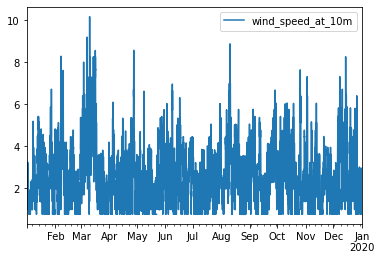

In [170]:
wind_speed.plot()
plt.show()

#### For all variables

Cycling through all the pollutant species:

In [ ]:
# Specify variables to be gridded
variables = list(new_ds.data_vars)[-4:-2]
variables

In [40]:
for variable in variables:
    print(variable)

    # Grid the timeseries data
    cell_list = []
    progress_bar = tqdm(range(0, new_ds.datetime.shape[0]))

    for i in progress_bar:
        progress_bar.set_description(f"Gridding timesteps")
        cell = ref_cell.copy()
        timestep_gdf = gpd.GeoDataFrame(new_ds[variable][i, :].values, 
                         columns=[f"timestep_{variable}"], 
                         geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))
        merge = gpd.sjoin(timestep_gdf, ref_cell, how="left", predicate="within")
        dissolve = merge.dissolve(by="index_right", aggfunc="mean")
        cell.loc[dissolve.index, f"timestep_{variable}"] = dissolve[f"timestep_{variable}"].values
        cell_list.append(cell[f"timestep_{variable}"].values.reshape(28,18))

    # Stack the grids into a numpy array
    timeseries_gridded = np.stack(cell_list, axis=-1)

    # Create the xarray dataset
    data_variables = {f"{variable}": (["longitude", "latitude", "time"], timeseries_gridded, new_ds[variable].attrs)
                        }

    coords = {"longitude": (["longitude"], ref_cell.centroid.x.drop_duplicates()),
                "latitude": (["latitude"], ref_cell.centroid.y.drop_duplicates()),
             "time": (["time"], new_ds.datetime.data)}

    attrs = new_ds.attrs

    timeseries_ds = xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

    # Save to a netCDF file
    filepath = path.join(folder, "gridded", f"{variable}_timeseries_grid.nc")
    timeseries_ds.to_netcdf(filepath)
    print(f"Saved to {filepath}.")

Gridding timesteps:   0%|          | 0/8760 [00:00<?, ?it/s]

CO2


Gridding timesteps:   0%|          | 0/8760 [00:00<?, ?it/s]

Saved to /home/users/mwlw3/ADMS-Urban/2019_CERC_subset/gridded/CO2_timeseries_grid.nc.
O3


Gridding timesteps:   0%|          | 0/8760 [00:00<?, ?it/s]

Saved to /home/users/mwlw3/ADMS-Urban/2019_CERC_subset/gridded/O3_timeseries_grid.nc.
wind_speed_at_10m


Gridding timesteps:   0%|          | 0/8760 [00:00<?, ?it/s]


ValueError: Length of values (20025) does not match length of index (8760)

#### Visualise the timeseries as an animation

In [36]:
variable = "NO2"

In [71]:
timeseries_ds = xr.open_dataset(path.join(folder, "gridded", f"{variable}_timeseries_grid.nc")).transpose("time", "latitude", "longitude")

In [123]:
daily_da = timeseries_ds[variable].groupby("time.dayofyear").mean("time")
daily_da.shape

(365, 18, 28)

In [124]:
frames = []

for i in tqdm(range(0, daily_da.dayofyear.size)):
    image = daily_da[dict(dayofyear=i)].plot(figsize=(10,5), 
                                                       cmap="plasma_r", 
                                                       vmin=0, 
                                                       vmax=daily_da.max())
    images_folder = path.join(path.abspath(""), "tmp", "gif_images")
    image_filepath = path.join(images_folder, f"{variable}_T{i}.png")
    plt.savefig(image_filepath)
    plt.close()

    new_frame = Image.open(image_filepath)
    frames.append(new_frame)
    remove(image_filepath)

frames[0].save(path.join(folder, f"{variable}_daily_mean_timeseries.gif"), format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)

100%|██████████| 365/365 [01:22<00:00,  4.42it/s]


KeyError: 'MP4'